# Selección de modelo

# Definiciones

In [1]:
# Bibliotecas

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import make_scorer, recall_score, f1_score, accuracy_score

In [2]:
# Definiciones globales

%run ../Lib/pandas_options.py
%run ../Lib/define_constantes.py

# Cargar datos

In [3]:
# Cargar datos ya preprocesados y dividirlos en variables independientes (X) y variable dependiente objetivo (Y)

archivo_datos_codificados = f'{DIRECTORIO_RESULTADOS}/DATOSCODIFICADOS.csv'
df_datos_codificados = pd.read_csv(archivo_datos_codificados, low_memory=False)

X = df_datos_codificados.drop('DETERIORADO', axis='columns')
Y = df_datos_codificados['DETERIORADO']

print('\nVariables de entrada (X):')
print(f'{len(X.columns)} columnas:\n{X.columns.to_list()}')
print('-' * 92)
print('\nVariable dependiente (Y):')
print(Y.info())
print(Y.value_counts().sort_index())


Variables de entrada (X):
20 columnas:
['EDAD', 'DIAMETRO', 'LONGITUD', 'AREA', 'PROF_BATEA', 'PROF_BATE1', 'PENDIENTE', 'ARRANQUE', 'ZONA_SUR', 'MUNICIPIO_MEDELLIN', 'ESTADO_OPERACION', 'TIPO_AGUA_COMBINADAS', 'TIPO_AGUA_LLUVIAS Y DESCARGAS', 'TIPO_AGUA_OTRAS', 'MATERIAL_CONCRETO REFORZADO Y OTROS', 'MATERIAL_CONCRETO SIMPLE', 'MATERIAL_PVC', 'FABRICANTE_INDUSTRIAS DIQUE S.A.', 'FABRICANTE_MEXICHEM COLOMBIA S.A.S.', 'FABRICANTE_OTROS']
--------------------------------------------------------------------------------------------

Variable dependiente (Y):
<class 'pandas.core.series.Series'>
RangeIndex: 27471 entries, 0 to 27470
Series name: DETERIORADO
Non-Null Count  Dtype
--------------  -----
27471 non-null  bool 
dtypes: bool(1)
memory usage: 27.0 KB
None
DETERIORADO
False    15002
True     12469
Name: count, dtype: int64


# Verificar balance de variable dependiente

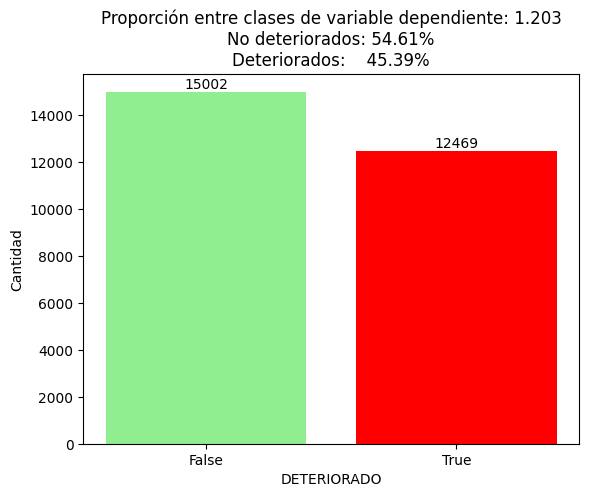

In [4]:
conteo_estado = Y.value_counts()
conteo_deteriorados = conteo_estado.get(True, 0)
conteo_nodeteriorados = conteo_estado.get(False, 0)
conteo_total = conteo_deteriorados + conteo_nodeteriorados

proporcion_FvsT = conteo_nodeteriorados / conteo_deteriorados 
proporcion_deteriorados = conteo_deteriorados / conteo_total
proporcion_nodeteriorados = conteo_nodeteriorados / conteo_total

plt.bar(conteo_estado.index.astype(str), conteo_estado.values, color=['lightgreen', 'red'])
for i, valor in enumerate(conteo_estado.values):
    plt.text(i, valor + 0.1, str(valor), ha='center', va='bottom')

plt.xlabel('DETERIORADO')
plt.ylabel('Cantidad')
plt.title(
    f'Proporción entre clases de variable dependiente: {proporcion_FvsT:.4}\n'
    f'No deteriorados: {proporcion_nodeteriorados:.2%}\n'
    f'Deteriorados:    {proporcion_deteriorados:.2%}'
)
plt.show()

# Crear estructuras para almacenar modelos y sus resultados

In [5]:
# Definir clase para evaluación de modelos
class EvaluacionModeloML:
    def __init__(self, modelo, param_grid={}):
        self.isTrained = False
        self.modelo = modelo
        self.param_grid = param_grid
        self.best_params = {}
        self.scoresCV = None # Para resultados de cross_validate

# Inicializar diccionario de evaluaciones
dict_evaluaciones = {}

# Rango de hiperparametros para tuneo de balanceo de clases
PESOS_DE_CLASES = [
    {False: 1, True: proporcion_FvsT},   # Aumentar peso a casos positivos
    {False: 1/proporcion_FvsT, True: 1}, # Reducir peso a casos negativos
]

for pesos in PESOS_DE_CLASES:
    print(pesos)

{False: 1, True: np.float64(1.2031437966156067)}
{False: np.float64(0.831155845887215), True: 1}


# Configurar modelos candidatos

### Logistic Regression

In [6]:
dict_evaluaciones['LGR'] = EvaluacionModeloML(
    modelo = LogisticRegression(),
    param_grid = {
        'C'                      : [1, 5],
        'class_weight'           : PESOS_DE_CLASES + [None, 'balanced'],
        #'dual'                   : [False, ],
        #'fit_intercept'          : [True, False, ],
        #'intercept_scaling'      : [1, 0.1, 10, ],
        #'l1_ratio'               : [None, ],
        #'max_iter'               : [100, 1000 ],
        #'multi_class'            : ['auto', ],
        'n_jobs'                 : [-1],
        #'penalty'                : ['l2', None],
        'solver'                 : ['newton-cholesky'], # n_samples >> n_features, one-hot encoded categorical features with rare categories
        #'tol'                    : [0.0001, 1e-05, 0.001, ],
        #'warm_start'             : [True, False],
    }
)

### Random Forest classifier

In [7]:
dict_evaluaciones['RFC'] = EvaluacionModeloML(
    modelo = RandomForestClassifier(),
    param_grid = {
        #'bootstrap'              : [False, ],
        'ccp_alpha'              : [0, 0.01, 0.05],   # muy sensible!! valor alto -> recall 1.0
        'class_weight'           : PESOS_DE_CLASES + [None, 'balanced', 'balanced_subsample'],
        # 'criterion'              : ['entropy'],
        'max_depth'              : [None, 10],
        # 'max_features'           : [None],
        #'max_leaf_nodes'         : [200,],
        #'max_samples'            : [None, ],
        #'min_impurity_decrease'  : [0.0, ],
        # 'min_samples_leaf'       : [2],
        # 'min_samples_split'      : [10, ],
        #'min_weight_fraction_leaf': [0.0, ],
        'n_estimators'           : [100, 200],
        'n_jobs'                 : [-1],
        #'oob_score'              : [False, True, ],
        # 'warm_start'             : [False],
    }
)

### Histogram-based Gradient Boosting Classification Tree

In [8]:
dict_evaluaciones['HGBC'] = EvaluacionModeloML(
    modelo = HistGradientBoostingClassifier(),
    param_grid = {
        # 'categorical_features'   : ['warn', ],
        'class_weight'           : PESOS_DE_CLASES + [None, 'balanced'],
        # 'interaction_cst'        : [None, ],
        'l2_regularization'      : [0, 1],
        'learning_rate'          : [0.015, 0.01, 0.1],
        # 'loss'                   : ['log_loss', ],
        #  'max_bins'               : [255],
        'max_depth'              : [None, 10],
        # 'max_features'           : [1.0, 0.1, 10.0, ],
        'max_iter'               : [100, 200],
        'max_leaf_nodes'         : [None, 31, 63],
        'min_samples_leaf'       : [10, 20, 30],
        # 'monotonic_cst'          : [None, ],
        # 'n_iter_no_change'       : [10],
        # 'scoring'                : ['loss'],
        # 'tol'                    : [1e-07, 1e-08, 1e-06, ],
        # 'validation_fraction'    : [0.1, 0.01, 1.0, ],
        # 'early_stopping'         : [False],
    }
)

### XGBoost

In [9]:
dict_evaluaciones['XGB'] = EvaluacionModeloML(
    modelo = XGBClassifier(),
    param_grid = {
        'objective'              : ['binary:logistic'],
        # 'base_score'             : [None, ],
        # 'booster'                : [None, ],
        # 'callbacks'              : [None, ],
        # 'colsample_bylevel'      : [None, ],
        # 'colsample_bynode'       : [None, ],
        # 'colsample_bytree'       : [None, ],
        # 'device'                 : ['gpu'],
        # 'early_stopping_rounds'  : [None, ],
        # 'enable_categorical'     : [False, True, ],
        'eval_metric'            : ['logloss', 'error'],
        # 'feature_types'          : [None, ],
        # 'gamma'                  : [None, ],
        # 'grow_policy'            : [None, ],
        # 'importance_type'        : [None, ],
        # 'interaction_constraints': [None, ],
        'learning_rate'          : [0.01, 0.1],
        # 'max_bin'                : [None, ],
        # 'max_cat_threshold'      : [None, ],
        # 'max_cat_to_onehot'      : [None, ],
        # 'max_delta_step'         : [None, ],
        'max_depth'              : [3, 6, 10],
        # 'max_leaves'             : [None, ],
        # 'min_child_weight'       : [0.05],
        # 'missing'                : [nan, nan, nan, ],
        # 'monotone_constraints'   : [None, ],
        # 'multi_strategy'         : [None, ],
        # 'n_estimators'           : [None, 500],
        'n_jobs'                 : [-1],
        # 'num_parallel_tree'      : [None, ],
        # 'reg_alpha'              : [0, 1],
        'reg_lambda'             : [1, 5, 10],
        # 'sampling_method'        : [None, ],
        'scale_pos_weight'       : [proporcion_FvsT, 1],
        # 'subsample'              : [0.5],
        # 'tree_method'            : [None, ],
        # 'validate_parameters'    : [None, ],
        # 'verbosity'              : [None, ],
    }
)

## Valores detectados

In [10]:
# Hiperparámetros hallados en última ejecución con valores en datos originales

# dict_evaluaciones["LGR"].best_params = {'C': 2, 'class_weight': {False: 1, True: np.float64(1.2031437966156067)}, 'n_jobs': -1, 'solver': 'newton-cholesky'}
# dict_evaluaciones["SVC"].best_params = {'C': 20, 'class_weight': {False: np.float64(0.831155845887215), True: 1}}
# dict_evaluaciones["RFC"].best_params = {'ccp_alpha': 0.05, 'class_weight': {False: 1, True: np.float64(1.2031437966156067)}, 'criterion': 'entropy', 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 2000, 'n_jobs': -1, 'warm_start': False}
# dict_evaluaciones["HGBC"].best_params = {'class_weight': {False: np.float64(0.831155845887215), True: 1}, 'early_stopping': False, 'l2_regularization': 1, 'learning_rate': 0.015, 'max_bins': 255, 'max_depth': None, 'max_iter': 100, 'max_leaf_nodes': 63, 'min_samples_leaf': 5, 'n_iter_no_change': 10, 'scoring': 'loss'}
# dict_evaluaciones["XGB01"].best_params = {'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 0.05, 'n_jobs': -1, 'objective': 'binary:logistic', 'reg_lambda': 10, 'scale_pos_weight': np.float64(1.2031437966156067), 'subsample': 0.5}


In [11]:
# Hiperparámetros hallados en ejecución con datos de CCTV actualizados a 2024-07

# --------------------------------------------------------------------------------
# dict_evaluaciones["LGR"].best_params = {'C': 5, 'class_weight': {False: 1, True: np.float64(1.2031437966156067)}, 'n_jobs': -1, 'solver': 'newton-cholesky'}
# dict_evaluaciones["RFC"].best_params = {'ccp_alpha': 0.05, 'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 100, 'n_jobs': -1}
# dict_evaluaciones["HGBC"].best_params = {'class_weight': 'balanced', 'l2_regularization': 0, 'learning_rate': 0.01, 'max_depth': 10, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 10}
# dict_evaluaciones["XGB"].best_params = {'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 3, 'n_jobs': -1, 'objective': 'binary:logistic', 'reg_lambda': 5, 'scale_pos_weight': np.float64(1.2031437966156067)}


## Separación de datos de entrenamiento y validación

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)

## Búsqueda de hiperparámetros de cada modelo

In [13]:
SCORER = make_scorer(recall_score)

print('Cálculo de hiperparámetros')
print('-' * 80)
for nombre, evaluacion in dict_evaluaciones.items():
    print(f'\n{nombre}')
    if evaluacion.isTrained:
        print('Ya entrenado.')
    elif evaluacion.best_params == {}: # Recalcular solo si es nuevo
        searchCV = GridSearchCV(
            evaluacion.modelo, evaluacion.param_grid,
            cv=5, 
            scoring=SCORER,
            verbose=5,
            #n_jobs=-1, 
        )
        searchCV.fit(x_train, y_train)
        evaluacion.modelo = searchCV.best_estimator_
        evaluacion.best_params = searchCV.best_params_
    else:
        print('Entrenando modelo con hiperparámetros previamente asignados...')
        evaluacion.modelo.set_params(**evaluacion.best_params)
        evaluacion.modelo.fit(x_train, y_train)

    evaluacion.isTrained = True
    print(f'Modelo:', evaluacion.modelo)
    print(evaluacion.modelo.get_params())
    print('-' * 80)

print(f'\nHiperparámetros calculados.')

Cálculo de hiperparámetros
--------------------------------------------------------------------------------

LGR
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END C=1, class_weight={False: 1, True: np.float64(1.2031437966156067)}, n_jobs=-1, solver=newton-cholesky;, score=0.771 total time=   1.5s
[CV 2/5] END C=1, class_weight={False: 1, True: np.float64(1.2031437966156067)}, n_jobs=-1, solver=newton-cholesky;, score=0.812 total time=   1.0s
[CV 3/5] END C=1, class_weight={False: 1, True: np.float64(1.2031437966156067)}, n_jobs=-1, solver=newton-cholesky;, score=0.800 total time=   0.9s
[CV 4/5] END C=1, class_weight={False: 1, True: np.float64(1.2031437966156067)}, n_jobs=-1, solver=newton-cholesky;, score=0.802 total time=   0.9s
[CV 5/5] END C=1, class_weight={False: 1, True: np.float64(1.2031437966156067)}, n_jobs=-1, solver=newton-cholesky;, score=0.809 total time=   0.8s
[CV 1/5] END C=1, class_weight={False: np.float64(0.831155845887215), True: 1}, n_jobs=

# Validación cruzada (*cross-validation*)

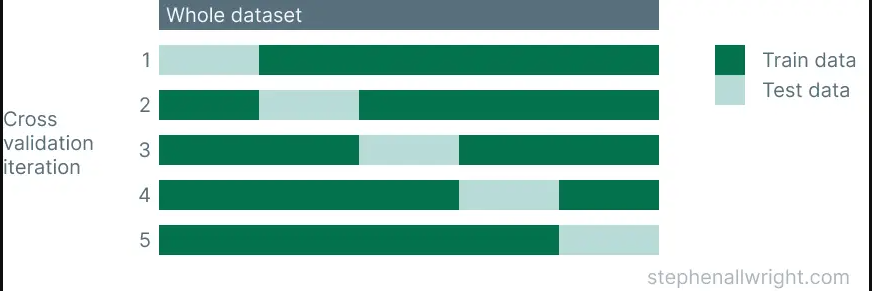

## Evaluación de rendimiento de cada modelo.

In [14]:
print('Rendimiento de cada modelo')
forzar_calculo = False
for nombre, evaluacion in dict_evaluaciones.items():
    print(f'{"-" * 100}')
    print(nombre)
    print(evaluacion.modelo)
    if forzar_calculo | (not evaluacion.scoresCV):
        print('Calculando...')
        evaluacion.scoresCV = cross_validate(
            estimator=evaluacion.modelo,
            X=x_test, y=y_test, 
            cv=10, 
            scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
            verbose=3,
            n_jobs=4,
        )
        print()

    df_scoresCV = pd.DataFrame(evaluacion.scoresCV)
    print(df_scoresCV.mean())

print('-' * 100)
print(f'\n\n** Cross-validation terminado **')

Rendimiento de cada modelo
----------------------------------------------------------------------------------------------------
LGR
LogisticRegression(C=5,
                   class_weight={False: 1,
                                 True: np.float64(1.2031437966156067)},
                   n_jobs=-1, solver='newton-cholesky')
Calculando...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    1.6s remaining:    0.6s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.



fit_time          0.020041
score_time        0.008150
test_accuracy     0.741554
test_f1           0.732664
test_precision    0.683977
test_recall       0.789495
test_roc_auc      0.803150
dtype: float64
----------------------------------------------------------------------------------------------------
RFC
RandomForestClassifier(ccp_alpha=0.05, class_weight='balanced', n_jobs=-1)
Calculando...


[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    1.4s remaining:    0.5s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.



fit_time          0.631634
score_time        0.096037
test_accuracy     0.735149
test_f1           0.735212
test_precision    0.667322
test_recall       0.819347
test_roc_auc      0.781477
dtype: float64
----------------------------------------------------------------------------------------------------
HGBC
HistGradientBoostingClassifier(class_weight='balanced', l2_regularization=0,
                               learning_rate=0.01, max_depth=10,
                               min_samples_leaf=10)
Calculando...


[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.



fit_time          0.543612
score_time        0.023660
test_accuracy     0.750873
test_f1           0.741579
test_precision    0.693971
test_recall       0.796957
test_roc_auc      0.811388
dtype: float64
----------------------------------------------------------------------------------------------------
XGB
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
     

[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.7s finished


# Visualizar métricas de modelos

In [15]:
# Generar tabla de métricas

data = {}
model_names = []
for nombre, evaluacion in dict_evaluaciones.items():
    scores = evaluacion.scoresCV
    model_names.append(nombre)
    data[nombre] = [
        scores['test_accuracy'].mean(),
        scores['test_f1'].mean(),
        scores['test_precision'].mean(),
        scores['test_recall'].mean(),
        scores['test_roc_auc'].mean(),        
    ]

df = pd.DataFrame(
    data,
    index=[
        'test_accuracy',
        'test_f1',
        'test_precision',
        'test_recall',
        'test_roc_auc',
    ]
)

df_normalized = pd.DataFrame(df.T, columns=df.index)

In [16]:
# Visualizar tabla

df_tabla_metricas = df_normalized.reset_index()
df_tabla_metricas.rename(
    columns={
        'index'          : 'MODELO',
        'test_accuracy'  : 'ACCURACY',
        'test_f1'        : 'F1',
        'test_precision' : 'PRECISION',
        'test_recall'    : 'RECALL',
        'test_roc_auc'   : 'ROC_AUC',
    },
    inplace=True,
)

#print(df_tabla_metricas[df_tabla_metricas['MODELO'] == 'RFC'])
print(f'Resultados de optimización por {SCORER}')
print('-' * 80)
display(df_tabla_metricas)

Resultados de optimización por make_scorer(recall_score, response_method='predict')
--------------------------------------------------------------------------------


,MODELO,ACCURACY,F1,PRECISION,RECALL,ROC_AUC
0,LGR,0.741554,0.732664,0.683977,0.789495,0.803150
1,RFC,0.735149,0.735212,0.667322,0.819347,0.781477
2,HGBC,0.750873,0.741579,0.693971,0.796957,0.811388
3,XGB,0.746507,0.740669,0.685453,0.806697,0.807167


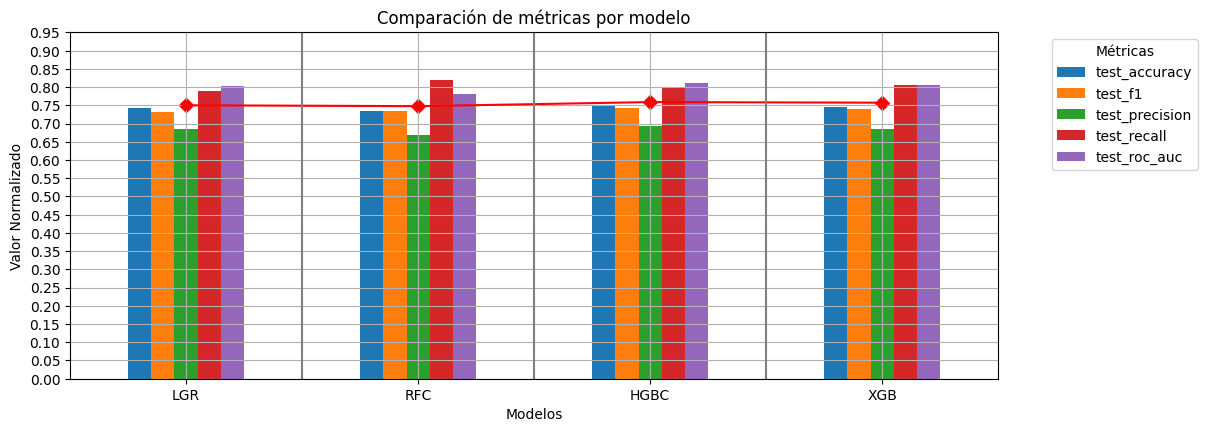

In [17]:
# Visualizar gráfico de barras comparativo

ax = df_normalized.plot(kind='bar', figsize=(13, 4))
ax.set_xticklabels(model_names, rotation=0, ha="center")

legend = ax.legend(title='Métricas', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.subplots_adjust(right=0.75)

averages = df_normalized.mean(axis=1)

for i, avg in enumerate(averages):
    plt.scatter(i, avg, marker='D', color='red', s=50)

# Primedio
plt.plot(averages.index, averages.values, marker='o', linestyle='-', color='red')
for i in range(1, len(model_names)):
    plt.axvline(x=i-0.5, color='gray', linestyle='-')

plt.yticks(np.arange(0, 1, 0.05))
plt.title('Comparación de métricas por modelo')
plt.xlabel('Modelos')
plt.ylabel('Valor Normalizado')
plt.grid()
plt.show()


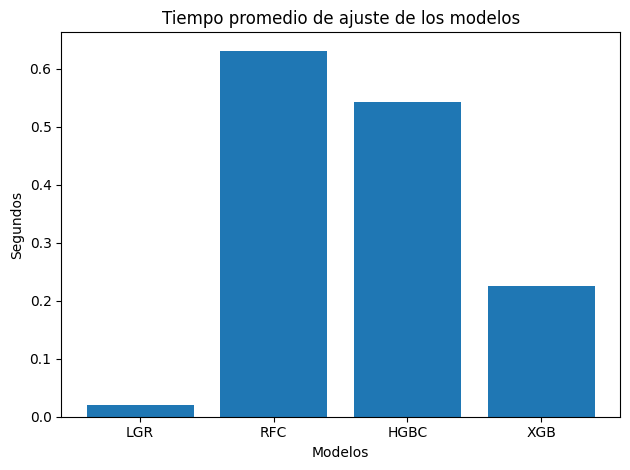

In [18]:
# Visualizar tiempos de ajuste

tiempos = [evaluacion.scoresCV['fit_time'].mean() for evaluacion in dict_evaluaciones.values()]
nombres = dict_evaluaciones.keys()

plt.bar(range(len(nombres)), tiempos)
plt.xticks(range(len(nombres)), nombres)
plt.xlabel('Modelos')
plt.ylabel('Segundos')
plt.title('Tiempo promedio de ajuste de los modelos')
plt.tight_layout()
plt.show()

# Curvas de calibración

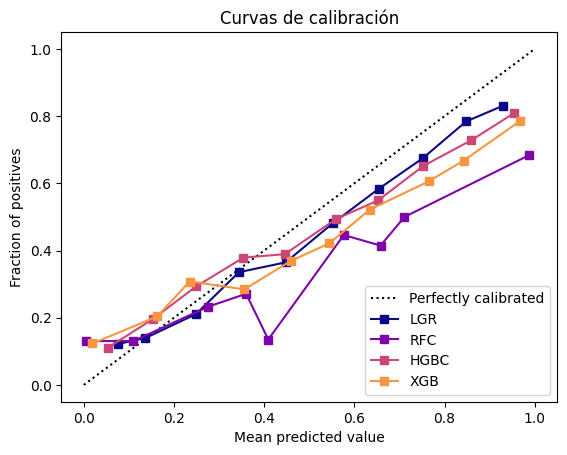

In [19]:
probabilidades = []
nombre_modelos = []
for nombre, evaluacion in dict_evaluaciones.items():
    # Incluir solo los modelos que incluyan predicción probabilística
    if hasattr(evaluacion.modelo, 'predict_proba'):
        probabilidades.append(evaluacion.modelo.predict_proba(x_test))
        nombre_modelos.append(nombre)

skplt.metrics.plot_calibration_curve(
    y_test, 
    probabilidades, 
    nombre_modelos,
    title='Curvas de calibración',
    cmap='plasma',
)
plt.show()

# Hiperparámetros detectados

In [20]:
print('#', '-' * 80)
print(f'# Resultados de optimización por {SCORER}')
print(f'# Proporción enter clases: {proporcion_FvsT}')
for linea in df_tabla_metricas.to_string(index=False).split('\n'):
    print(f'# {linea}')
    
print('#', '-' * 80)

for nombre, evaluacion in dict_evaluaciones.items():
    modelo_str = ' '.join([linea.strip() for linea in repr(evaluacion.modelo).split('\n')])
    print(f'# {modelo_str}')
    #print(f'# Full parameters = {evaluacion.modelo.get_params()}')

print('#', '-' * 80)

for nombre, evaluacion in dict_evaluaciones.items():
    print(f'# dict_evaluaciones["{nombre}"].best_params = {evaluacion.best_params}')
    #print('\n#', '-' * 80)

print()


# --------------------------------------------------------------------------------
# Resultados de optimización por make_scorer(recall_score, response_method='predict')
# Proporción enter clases: 1.2031437966156067
# MODELO  ACCURACY       F1  PRECISION   RECALL  ROC_AUC
#    LGR  0.741554 0.732664   0.683977 0.789495 0.803150
#    RFC  0.735149 0.735212   0.667322 0.819347 0.781477
#   HGBC  0.750873 0.741579   0.693971 0.796957 0.811388
#    XGB  0.746507 0.740669   0.685453 0.806697 0.807167
# --------------------------------------------------------------------------------
# LogisticRegression(C=5, class_weight={False: 1, True: np.float64(1.2031437966156067)}, n_jobs=-1, solver='newton-cholesky')
# RandomForestClassifier(ccp_alpha=0.05, class_weight='balanced', n_jobs=-1)
# HistGradientBoostingClassifier(class_weight='balanced', l2_regularization=0, learning_rate=0.01, max_depth=10, min_samples_leaf=10)
# XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel